[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\14ZD\miniconda3\lib\site-packages\torch\nn\functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode [100/3000]\Total Capture: $129,259,581.62
Episode [200/3000]\Total Capture: $129,080,475.00
Episode [300/3000]\Total Capture: $129,080,475.00
Episode [400/3000]\Total Capture: $129,080,475.00
Episode [500/3000]\Total Capture: $129,080,475.00
Episode [600/3000]\Total Capture: $129,080,475.00
Episode [700/3000]\Total Capture: $129,080,475.00
Episode [800/3000]\Total Capture: $129,080,475.00
Episode [900/3000]\Total Capture: $129,080,475.00
Episode [1000/3000]\Total Capture: $129,080,475.00
Episode [1100/3000]\Total Capture: $129,080,475.00
Episode [1200/3000]\Total Capture: $129,080,475.00
Episode [1300/3000]\Total Capture: $129,080,475.00
Episode [1400/3000]\Total Capture: $129,080,475.00
Episode [1500/3000]\Total Capture: $129,080,475.00
Episode [1600/3000]\Total Capture: $129,080,475.00
Episode [1700/3000]\Total Capture: $129,080,475.00
Episode [1800/3000]\Total Capture: $129,080,475.00
Episode [1900/3000]\Total Capture: $129,080,475.00
Episode [2000/3000]\Total Capture: $129,

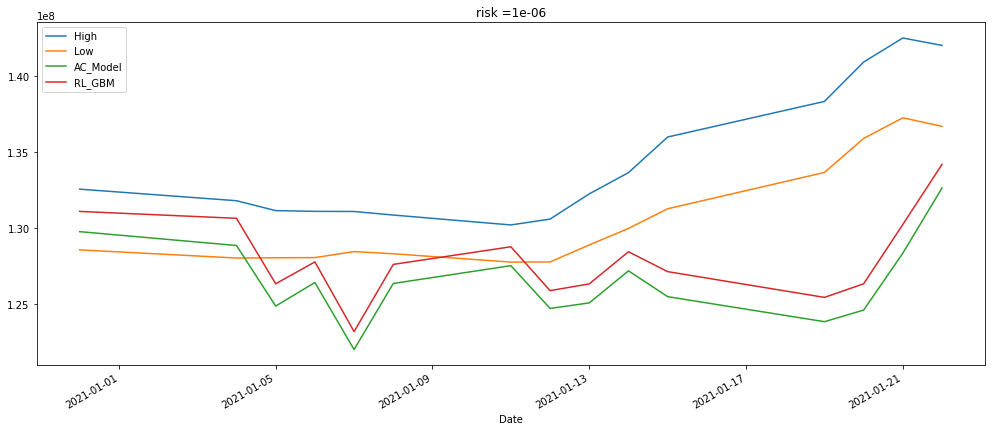

In [3]:
import pandas as pd
import copy
import syntheticChrissAlmgren2 as sca
import utils
import numpy as np
import yfinance as yf
import time
import sys
import matplotlib.pyplot as plt
from datetime import date, timedelta
from ddpg_agent import Agent
from collections import deque



class AC_model():
    def __init__(self, TOTAL_SHARES, NUM_TRADES, LIQUIDATION_TIME, start_date, end_date, ticker, ANNUAL_VOLAT, BID_ASK_SP, llambda_list):
        
        self.TOTAL_SHARES = TOTAL_SHARES
        self.NUM_TRADES = NUM_TRADES
        self.LIQUIDATION_TIME = LIQUIDATION_TIME
        self.start_date = start_date
        self.end_date = end_date
        self.ticker = ticker

        self.subtract_days = timedelta(NUM_TRADES)
        self.num_shares, self.last_num_shares = self.round_num_shares(self.TOTAL_SHARES, self.NUM_TRADES)
        self.data_origin =yf.download(ticker, start=start_date, end=end_date)
        self.TRAD_DAYS = len(self.data_origin['Open'])
        self.slidingwindow_num = self.TRAD_DAYS - NUM_TRADES + 1
        self.randomseed = 0                                
        self.BID_ASK_SP = BID_ASK_SP
        self.tau = 1
        self.DAILY_VOLAT = ANNUAL_VOLAT / np.sqrt(self.TRAD_DAYS)
        self.index_list = self.data_origin.index[:]
        self.llambda_list= llambda_list
        
        #DataFrame for Total Capture of "High" Price Execution and "Low" Price Execution
        self.df = yf.download(ticker, start = start_date-timedelta(self.TRAD_DAYS), end = end_date)
        self.df_trad = self.df.tail(self.TRAD_DAYS)
        self.total_cash_list, self.date_list = self.calculate_revenue(self.df_trad, 'High', self.slidingwindow_num, 
                                                       self.NUM_TRADES, self.num_shares, self.last_num_shares)
        self.frame1 = pd.DataFrame({"Date": self.date_list, "High": self.total_cash_list})

        self.total_cash_list2, self.date_list2 = self.calculate_revenue(self.df_trad, 'Low', self.slidingwindow_num, 
                                                       self.NUM_TRADES, self.num_shares, self.last_num_shares)
        self.frame2 = pd.DataFrame({"Date": self.date_list2, "Low": self.total_cash_list2})

    
    #TWAP method for determining number of shares to trade each day
    def round_num_shares(self, total_shares, num_trades):
        num_shares = total_shares // num_trades + 1
        last_num_shares = num_shares
        if type(total_shares / num_trades) != int:
            last_num_shares = total_shares - (num_shares*(num_trades-1))

        return num_shares, last_num_shares

    
    #Calculation of Total Capture of "High", "Low" Price Execution
    def calculate_revenue(self, df, category, slidingwindow_num, NUM_TRADES, num_shares, last_num_shares):
        total_cash_list = []
        date_list = []
        for window_num in range(slidingwindow_num):
            total_cash = 0
            for idx in range(NUM_TRADES):
                price = df[category][window_num:window_num+NUM_TRADES][idx]
                if idx == NUM_TRADES:
                    daily_cash = price * last_num_shares
                else:
                    daily_cash = price * num_shares
                total_cash += daily_cash
            total_cash_list.append(int(total_cash))
            date_list.append(df[category].index[window_num])

        return total_cash_list, date_list
    
    
    #Simulation to identify if AC Model fits between "High" and "Low" Price Execution Band
    def simulate_ac_model(self, episodes):
        for risk in self.llambda_list:
            llambda = risk
            cnt = 0
            
            #Previous Stock Data with length of Liquidation Time is used for parameter calibration
            start = -abs(self.TRAD_DAYS+self.LIQUIDATION_TIME)
            end = -abs(self.TRAD_DAYS)
            ac_date_list =[]
            Actual_Revenue_List = []
            capture_list = []
            rl_capture_list =[]

            for idx in range(self.slidingwindow_num):
                data = self.df.iloc[start:end]
                if end+NUM_TRADES != 0:
                    data_real_price = self.data_origin.iloc[end:end+self.NUM_TRADES]['Open'].to_numpy()
                else:
                    data_real_price = self.data_origin.iloc[end:]['Open'].to_numpy()

                today = self.df.index[end]
                ac_date_list.append(today)

                
                #Financial Parameters Calibration Using Past Stock Data
                average_daily_volume = np.mean(data['Volume'])
                average_daily_spread = np.mean(data['High'] - data['Low'])
                epsilon = average_daily_spread/2
                eta = average_daily_spread/(0.01*average_daily_volume)
                gamma = average_daily_spread/(0.1*average_daily_volume)

                startingPrice = data.tail(1)['Close'][0]
                singleStepVariance = (self.DAILY_VOLAT  * startingPrice) ** 2
                
                #AC Environment Initialized with new financial parameters
                env = sca.MarketEnvironment()
                env.__init__(0, self.LIQUIDATION_TIME, self.NUM_TRADES,
                             llambda, startingPrice, epsilon, 
                             eta, gamma, 
                             self.TOTAL_SHARES, singleStepVariance)

                # Get the trading list from the environment
                trl = env.get_trade_list()

                # Since we are not selling fractional shares we round up the shares in the trading list
                trade_list = utils.round_trade_list(trl)
            
                # Implement the trading list in our similation environment            
                env.start_transactions()      
                price_hist = np.array([])
                                      
                for trade in trade_list:
                    # Normal AC Total Capture Calculation
                    # Convert the number of shares to sell in each trade into an action
                    action = trade / env.shares_remaining

                    # Take a step in the environment my selling the number of shares in the current trade
                    _, _, _, info = env.step(action)

                    # Get the impacted price from the environment
                    price_hist = np.append(price_hist, info.exec_price)
                    if info.done:
                        capture = info.totalCapture

                    # If all shares have been sold, stop making transactions and get the implementation shortfall
                    if info.done:
                        #print('Implementation Shortfall: ${:,.2f} \n'.format(info.implementation_shortfall))
                        break


                final_trade_list = np.trim_zeros(trade_list.astype(int))
                capture_list.append(int(capture))
                
                #print("AC Capture:", capture)

                if len(final_trade_list) != len(data_real_price):
                    length = len(final_trade_list)
                    modified_data_real_price = data_real_price[:length]
                else:
                    modified_data_real_price = data_real_price

                Actual_Revenue_append = int(np.sum(final_trade_list*modified_data_real_price))
                Actual_Revenue_List.append(Actual_Revenue_append)
                
                
                #Create RL Environment
                rl_env = sca.MarketEnvironment()
                rl_env.__init__(0, self.LIQUIDATION_TIME, self.NUM_TRADES,
                             llambda, startingPrice, epsilon, 
                             eta, gamma, 
                             self.TOTAL_SHARES, singleStepVariance)
                
                rl_trl = rl_env.get_trade_list()
                rl_trade_list = utils.round_trade_list(trl)

            
                agent = Agent(state_size=rl_env.observation_space_dimension(), action_size=rl_env.action_space_dimension(), 
                              random_seed=0)
                
                rl_capture_hist = np.array([])
                rl_capture_deque = deque(maxlen=100)
                
                #Run Episodes for Reinforcement Learning
                for episode in range(episodes):
                    
                    #Reset RL Environment in every episode
                    rl_env.__init__(0, self.LIQUIDATION_TIME, self.NUM_TRADES,
                             llambda, startingPrice, epsilon, 
                             eta, gamma, 
                             self.TOTAL_SHARES, singleStepVariance)
                                    
                    rl_trl = rl_env.get_trade_list()
                    rl_trade_list = utils.round_trade_list(trl)
                    cur_state = np.array(list(rl_env.logReturns) + [rl_env.timeHorizon / rl_env.num_n, \
                                                                           rl_env.shares_remaining / rl_env.total_shares])
                    
                    rl_env.start_transactions()
        
                    for trade in rl_trade_list:
                        #RL Total Capture Learning
                        rl_action = agent.act(cur_state, add_noise = True)

                        new_state, rl_reward, done, rl_info = rl_env.step(rl_action)

                        agent.step(cur_state, rl_action, rl_reward, new_state, done)

                        cur_state = new_state
#                         if (episode + 1) % 100 == 0:
#                             print(cur_state)

                        if rl_info.done:
                            rl_capture_hist = np.append(rl_capture_hist, int(rl_info.totalCapture))
                            rl_capture_deque.append(int(rl_info.totalCapture))
                            break
                    
                    
                    if idx == 0:
                        if (episode + 1) % 100 == 0:
                            
                            print('\rEpisode [{}/{}]\Total Capture: ${:,.2f}'.format(episode + 1, episodes, np.mean(rl_capture_deque)))
                    
                    if episode+1 ==  episodes:
                        #print(rl_trade_list)
                        print('\rEpisode [{}/{}]\Total Capture: ${:,.2f}'.format(episode + 1, episodes, np.mean(rl_capture_deque)))

                        
                #Append Extracted Total Capture of a specified liquidation start date        
                rl_capture_list = np.append(rl_capture_list, np.mean(rl_capture_deque))
                
             
                start += 1
                end += 1

                
                
#                 #GBM Price Chart with High, Low price band
#                 if llambda == 1e-10 and idx == 0:
#                     price_list_num = len(price_hist)
                    
#                     GBM_price_frame = pd.DataFrame({"Date":self.index_list[:price_list_num], "Price": price_hist})
#                     GBM_price_frame.set_index("Date", inplace = True)
#                     REAL_LOW_price_frame = self.data_origin['Low'].head(price_list_num)
                    
#                     REAL_HIGH_price_frame = self.data_origin['High'].head(price_list_num)
#                     realFrame = pd.merge(REAL_LOW_price_frame, REAL_HIGH_price_frame,left_index=True, right_index=True)
#                     finalFrame = pd.merge(realFrame,GBM_price_frame, left_index=True, right_index=True)
#                     finalFrame.plot()
                
    
#                 #Stopping on a first date to check the ability of RL method compared to normal AC optimization
#                 if idx == 0:
#                     break


            #Plot Total Capture Comparison Graph of slidingwindow    
            rlframe = pd.DataFrame({"Date": ac_date_list, "RL_GBM": rl_capture_list})
            ACframe = pd.DataFrame({"Date": ac_date_list, "AC_Model":capture_list})
            ARframe = pd.DataFrame({"Date": ac_date_list, "Actual_Revenue": Actual_Revenue_List})
            newframe = pd.merge(self.frame1, self.frame2, how='inner', on='Date').merge(ACframe, on = 'Date').merge(rlframe, on="Date")
            newframe.set_index("Date", inplace=True)

            plt.rcParams['figure.figsize'] = [17.0, 7.0]
            titleName = "risk =" + str(llambda)
            newframe.plot(title = titleName)


            
            

TOTAL_SHARES = 1000000
NUM_TRADES = 6
LIQUIDATION_TIME = 6
start_date = date(2021,1,1)
end_date = '2021-02-01'
ticker = 'AAPL'
ANNUAL_VOLAT = 0.12                                
BID_ASK_SP = 1 / 8                                                                 
llambda_list= [1e-06]
plt.rcParams['figure.figsize'] = [17.0, 7.0]
EPISODES = 3000

simulation = AC_model(TOTAL_SHARES, NUM_TRADES, LIQUIDATION_TIME, start_date, end_date, ticker, ANNUAL_VOLAT, BID_ASK_SP, llambda_list)
simulation.simulate_ac_model(EPISODES)

